# Image classification for identification of eye diseases using eye disease retinal image dataset.
##### Auther of this notebook:
    Md. Saif Ahammod Khan
    ID: 2315333650
    

## 1. Importing The Required Libraries

In [1]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from PIL import Image

In [2]:
# Checking GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  0
2.14.0


'3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]'

## 2. Importing Dataset
Dataset link:

In [3]:
# Please input your local path of the dataset
# E.G "E:\Workplace\Projects\Eye disease detection\dataset"
local_path = 'E:\Workplace\Projects\Eye disease detection\dataset'
data_dir = pathlib.Path(local_path)

## 3. Data Visualization

### 3.1 Counting Total Image

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2918


### 3.2 Counting Total Class

In [5]:
# Get a list of subdirectories in data_dir
subdirectories = [item for item in data_dir.iterdir() if item.is_dir()]

# Count the number of subdirectories, which represents the number of classes
num_classes = len(subdirectories)

print("Number of classes:", num_classes)

Number of classes: 4


### 3.3 Counting The The Number of Images In Each Class

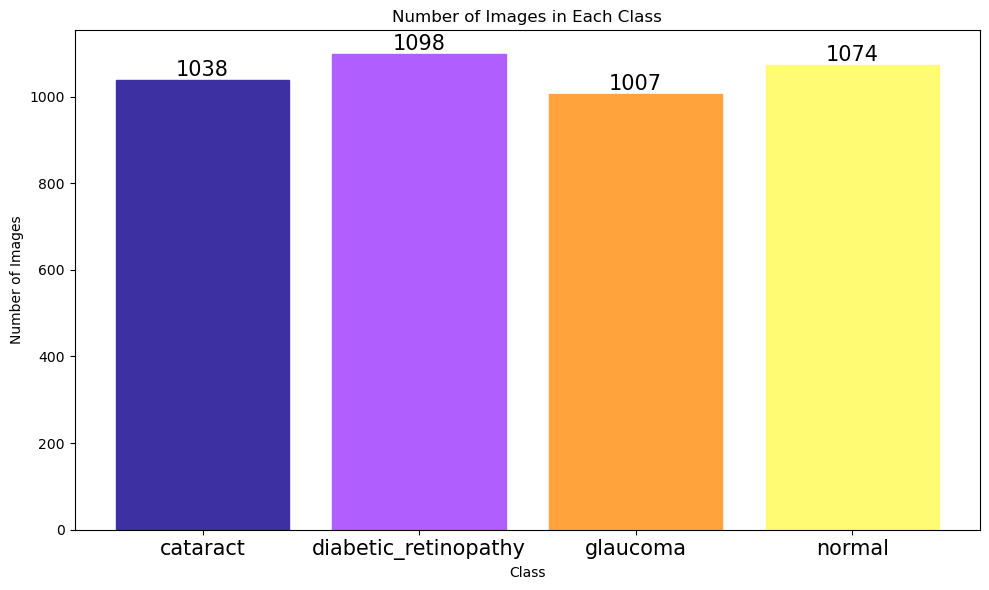

In [6]:
# Initialize a dictionary to store class names and image counts
class_counts = {}
# Iterate through subdirectories (classes) in data_dir
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        # Count the number of image files in the class directory
        image_count = len([f for f in class_dir.iterdir() if f.is_file()])
        class_counts[class_name] = image_count
# Extract class names and counts for plotting
class_names = list(class_counts.keys())
image_counts = list(class_counts.values())
# Define a list of colors for the bars (you can customize the colors)
colors = [plt.cm.viridis(random.random()) for _ in class_names]
# Create a bar chart with custom colors
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, image_counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=0, fontsize=15, ha="center")
# Customize the colors of the bars
# Define a list of custom colors for the bars
custom_colors = ['#3D30A2', '#B15EFF', '#FFA33C', '#FFFB73']
c=0
for bar, color in zip(bars, colors):
    bar.set_color(custom_colors[c])
    c=c+1
# Add count labels on top of the bars
for bar, count in zip(bars, image_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count, str(count),fontsize=15, ha='center', va='bottom')
plt.tight_layout()
# Show the bar chart
plt.show()

### 3.4 Data Sample Visualization of Each Class

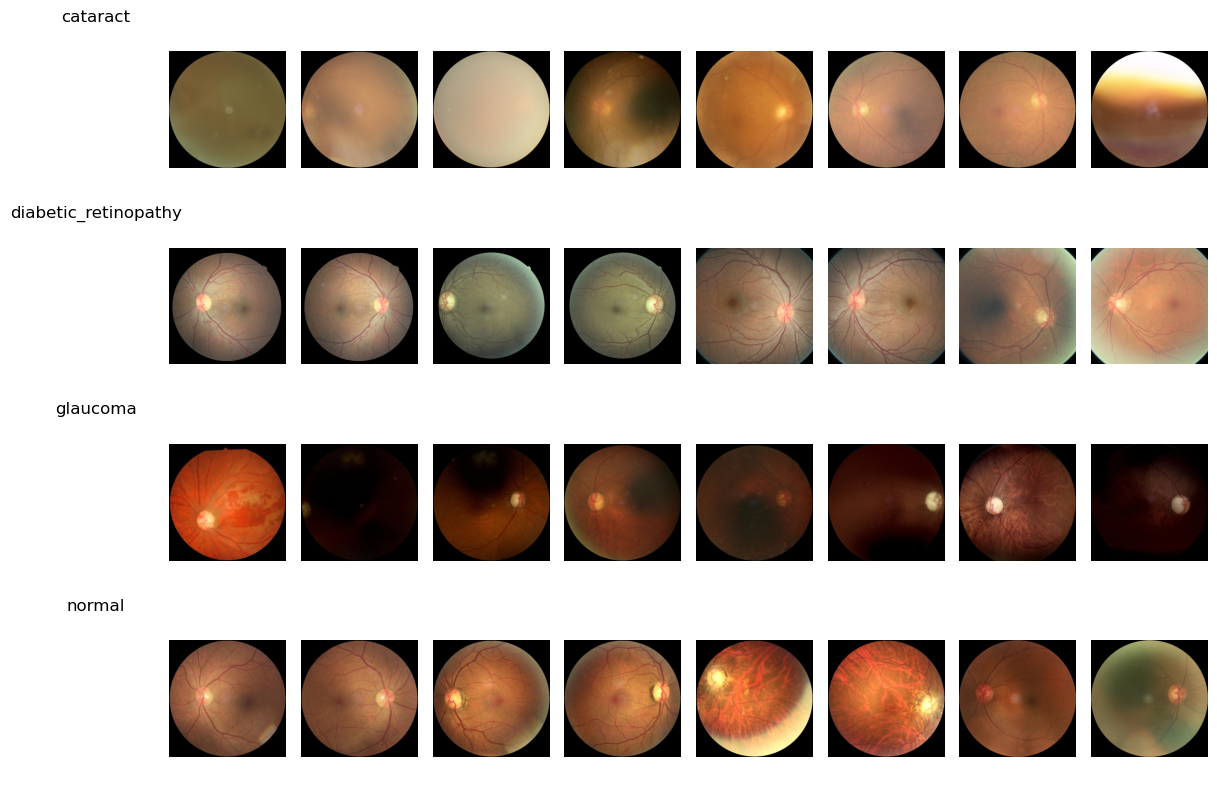

In [7]:

# Show 8 images from each class
num_images_to_display = 8  # Display 8 images for each class

num_rows = len(class_names)
num_cols = num_images_to_display + 1  # +1 for the title

plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names):
    class_dir = data_dir / class_name
    image_files = list(class_dir.glob('*.*'))
    if image_files:
        plt.subplot(num_rows, num_cols, i * num_cols + 1)
        plt.title(class_name)
        plt.axis('off')
        for j in range(num_images_to_display):
            if j < len(image_files):
                sample_image = Image.open(image_files[j])
                plt.subplot(num_rows, num_cols, i * num_cols + j + 2)
                plt.imshow(sample_image)
                plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Assign Values To Parameter

In [8]:
classes = sorted(os.listdir(data_dir))
classes

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [9]:
image_size = (512, 512)
batch_size = 64
epoch = 15


## 5. Data Partitioning

### 5.1 Train & Test Partiotioning

In [10]:
# Define the directories for the training, validation, and test sets
train_dir = 'E:\Workplace\Projects\Eye disease detection\splited_dataset\dtrain'
test_dir = 'E:\Workplace\Projects\Eye disease detection\splited_dataset\dtest'

# Define the class labels (assuming you have four classes)
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
# Define the percentages for each split
train_split = 0.85
test_split = 0.15

# Iterate over the classes and create subdirectories for each split
for class_name in classes:
    class_directory = os.path.join(local_path, class_name)
    images = os.listdir(class_directory)
    random.shuffle(images)

    # Calculate the number of images for each split
    num_images = len(images)
    num_train = int(train_split * num_images)


    # Create subdirectories for each split
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)

    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy images to the respective split directories
    for i, image in enumerate(images):
        source_path = os.path.join(class_directory, image)
        if i < num_train:
            destination_dir = train_dir
        else:
            destination_dir = test_dir
        destination_path = os.path.join(destination_dir, class_name, image)
        shutil.copy(source_path, destination_path)
print("Data partitioning was successfull!!!")

Data partitioning was successfull!!!


### 5.2 Count & Visualize Data After Partition

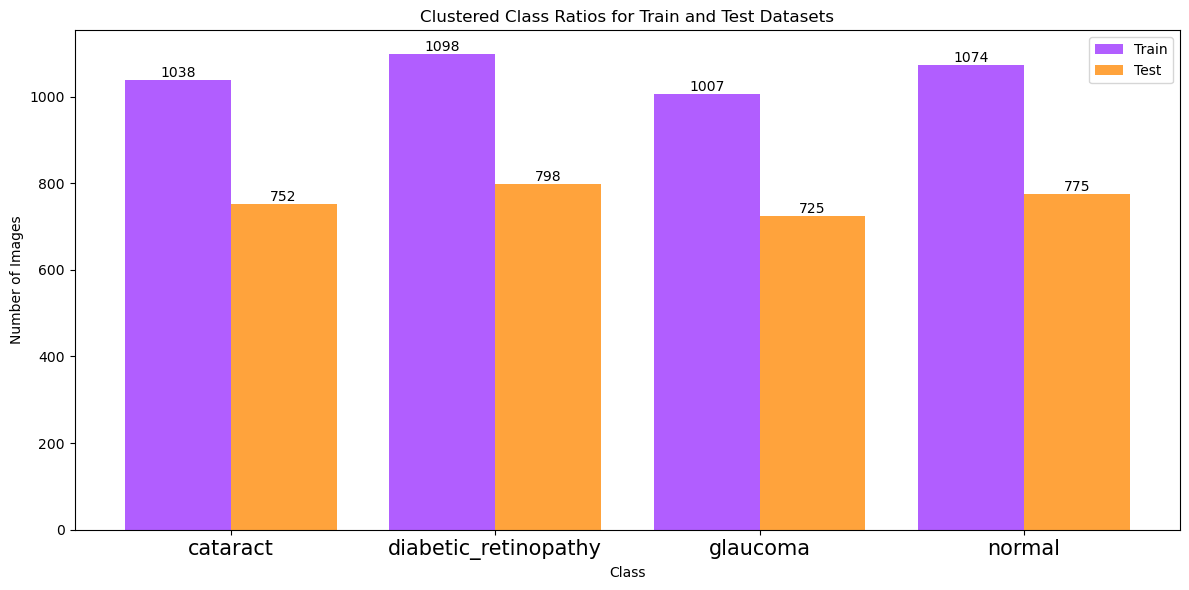

In [11]:
# Define the paths to your train and test datasets
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)

# Initialize dictionaries to store class counts for train and test
train_class_counts = {}
test_class_counts = {}

# Count the number of images for each class in the train dataset
for class_dir in train_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        image_count = len(list(class_dir.glob('*.*')))
        train_class_counts[class_name] = image_count

# Count the number of images for each class in the test dataset
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        image_count = len(list(class_dir.glob('*.*')))
        test_class_counts[class_name] = image_count

# Extract class names and counts for plotting
train_class_names = list(train_class_counts.keys())
train_image_counts = list(train_class_counts.values())

test_class_names = list(test_class_counts.keys())
test_image_counts = list(test_class_counts.values())

# Combine the train and test data for plotting
all_class_names = train_class_names
train_image_counts = np.array(train_image_counts)
test_image_counts = np.array(test_image_counts)

x = np.arange(len(all_class_names))
width = 0.40

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_image_counts, width, label='Train', color='#B15EFF')
plt.bar(x + width/2, test_image_counts, width, label='Test', color='#FFA33C')
plt.title('Clustered Class Ratios for Train and Test Datasets')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.legend()
plt.xticks(x, all_class_names, rotation=0, fontsize=15, ha="center")

# Add count labels on top of the bars
for i, count in enumerate(train_image_counts):
    plt.text(x[i] - width/2, count, str(count), ha='center', va='bottom', fontsize=10, color='black')
for i, count in enumerate(test_image_counts):
    plt.text(x[i] + width/2, count, str(count), ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

## 6. ResNet-50
ResNet stands for Residual Network and is a specific type of convolutional neural network that is 50 layers deep

### 6.1 Creating Subset

In [12]:
preprocess_input1 = tf.keras.applications.resnet50.preprocess_input

#### 6.1.1 Creating Training Subset

In [13]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input1,
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 3376 images belonging to 4 classes.


#### 6.1.2 Creating Test Subset

In [14]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input1)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2863 images belonging to 4 classes.


#### 6.1.3 Ceating Validation Subset

In [15]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 841 images belonging to 4 classes.


### 6.2 Model

In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
num_classes = len(class_names)
predictions = Dense(num_classes, activation='softmax')(x)

modelRN = Model(inputs=base_model.input, outputs=predictions)

modelRN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelRN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 128, 128, 64)         16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 128, 128, 64)         256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 128, 128, 64)         0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 64, 64, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 64, 64, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 64, 64, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 32, 32, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 32, 32, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 32, 32, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 32, 32, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 32, 32, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 32, 32, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 32, 32, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 32, 32, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 32, 32, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 32, 32, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 16, 16, 512)          0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 16, 16, 512)          2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 16, 16, 512)          2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 16, 16, 512)          0         ['conv5_block3_2_bn[0][0]']   
 ation)   

### 6.3 Model Train & Validation

In [17]:
train_steps_per_epoch = train_generator.samples // batch_size
val_steps_per_epoch = validation_generator.samples // batch_size

In [18]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.train_acc = []
        self.train_loss = []
        self.val_acc = []
        self.val_loss = []
        self.batch_nums = []

    def on_train_batch_end(self, batch, logs=None):
        self.train_acc.append(logs.get('accuracy'))
        self.train_loss.append(logs.get('loss'))
        self.batch_nums.append(batch)

    def on_test_batch_end(self, batch, logs=None):
        self.val_acc.append(logs.get('accuracy'))
        self.val_loss.append(logs.get('loss'))

metrics_callback = MetricsCallback()

In [19]:
historyRN = modelRN.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[metrics_callback]
)

Epoch 1/15
52/52 [==============================] - 1484s 29s/step - loss: 0.5880 - accuracy: 0.7579 - val_loss: 0.7224 - val_accuracy: 0.7031
Epoch 2/15
52/52 [==============================] - 1499s 29s/step - loss: 0.3541 - accuracy: 0.8792 - val_loss: 0.6130 - val_accuracy: 0.7500
Epoch 3/15
52/52 [==============================] - 1472s 28s/step - loss: 0.2959 - accuracy: 0.9040 - val_loss: 0.6670 - val_accuracy: 0.7404
Epoch 4/15
52/52 [==============================] - 1473s 28s/step - loss: 0.2709 - accuracy: 0.9133 - val_loss: 0.5700 - val_accuracy: 0.7632
Epoch 5/15
52/52 [==============================] - 1474s 29s/step - loss: 0.2569 - accuracy: 0.9094 - val_loss: 0.6876 - val_accuracy: 0.7344
Epoch 6/15
52/52 [==============================] - 1473s 28s/step - loss: 0.2359 - accuracy: 0.9221 - val_loss: 0.4962 - val_accuracy: 0.7837
Epoch 7/15
52/52 [==============================] - 1472s 28s/step - loss: 0.2234 - accuracy: 0.9233 - val_loss: 0.6333 - val_accuracy: 0.7392

### 6.4 Results

#### 6.4.1 Model Train Status

In [20]:
historyRN.history

{'loss': [0.5879743695259094,
  0.35407009720802307,
  0.29586729407310486,
  0.2709481120109558,
  0.256904661655426,
  0.2359258532524109,
  0.22343002259731293,
  0.2170131653547287,
  0.20153138041496277,
  0.19870740175247192,
  0.18286864459514618,
  0.17892859876155853,
  0.16883327066898346,
  0.16541801393032074,
  0.16224029660224915],
 'accuracy': [0.7578502297401428,
  0.8792270421981812,
  0.9039855003356934,
  0.9133453965187073,
  0.9094203114509583,
  0.9221014380455017,
  0.9233092069625854,
  0.9269323945045471,
  0.9305555820465088,
  0.9320651888847351,
  0.936292290687561,
  0.9384058117866516,
  0.9423308968544006,
  0.9441425204277039,
  0.9459540843963623],
 'val_loss': [0.7224327325820923,
  0.6129578351974487,
  0.6669813990592957,
  0.5700228810310364,
  0.6876262426376343,
  0.4961807429790497,
  0.6332983374595642,
  0.5021771788597107,
  0.5962181091308594,
  0.5432331562042236,
  0.6907304525375366,
  0.5571810007095337,
  0.5397271513938904,
  0.59423720

In [26]:
final_accuracy = historyRN.history['accuracy'][-1]  # Training accuracy from the last epoch
final_val_accuracy = historyRN.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

print(f'Final Training Accuracy: {final_accuracy:.4}')
print(f'Final Validation Accuracy: {final_val_accuracy:.4}')


Final Training Accuracy: 0.946
Final Validation Accuracy: 0.7764


In [27]:
train_accuracy = historyRN.history['accuracy']
val_accuracy = historyRN.history['val_accuracy']
train_loss = historyRN.history['loss']
val_loss = historyRN.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)
train_accuracy
epochs

range(1, 16)

#### 6.4.2 Traning And Validation Accuracy

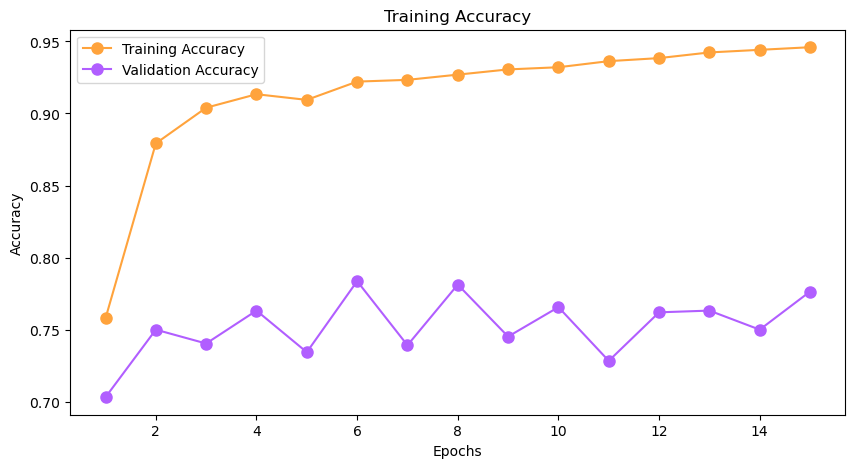

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
plt.plot(epochs, train_accuracy, '#FFA33C', marker='o', linestyle='-', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_accuracy, '#B15EFF',marker='o', linestyle='-', markersize=8, label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 6.4.3 Traning And Validation Loss

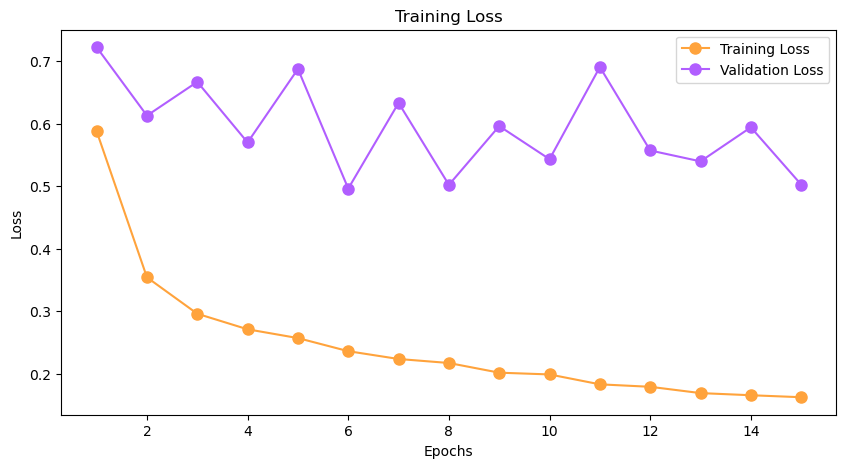

In [29]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, '#FFA33C', marker='o', linestyle='-', markersize=8, label='Training Loss')
plt.plot(epochs, val_loss, '#B15EFF', marker='o', linestyle='-', markersize=8, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 6.4.4 Data Prediction

In [30]:
predictions = modelRN.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

45/45 [==============================] - 1030s 23s/step


In [31]:
predicted_classes

array([0, 0, 3, ..., 3, 3, 3], dtype=int64)

In [32]:
true_classes

array([0, 0, 0, ..., 3, 3, 3])

#### 6.4.5 Model Accuricy

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
class_labels = list(train_generator.class_indices.keys())
# class_labels = class_names
classification_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(classification_report)

                      precision    recall  f1-score   support

            cataract       0.94      0.93      0.94       708
diabetic_retinopathy       1.00      0.99      0.99       746
            glaucoma       0.93      0.78      0.85       687
              normal       0.82      0.96      0.89       722

            accuracy                           0.92      2863
           macro avg       0.92      0.92      0.92      2863
        weighted avg       0.92      0.92      0.92      2863



#### 6.4.6 Confusion Matrix

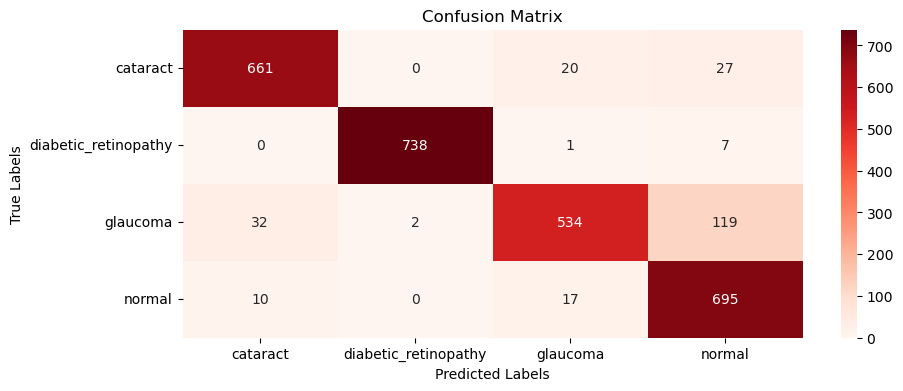

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### 6.4.7 ROC Curve

ROC AUC score: 0.9904553855305671


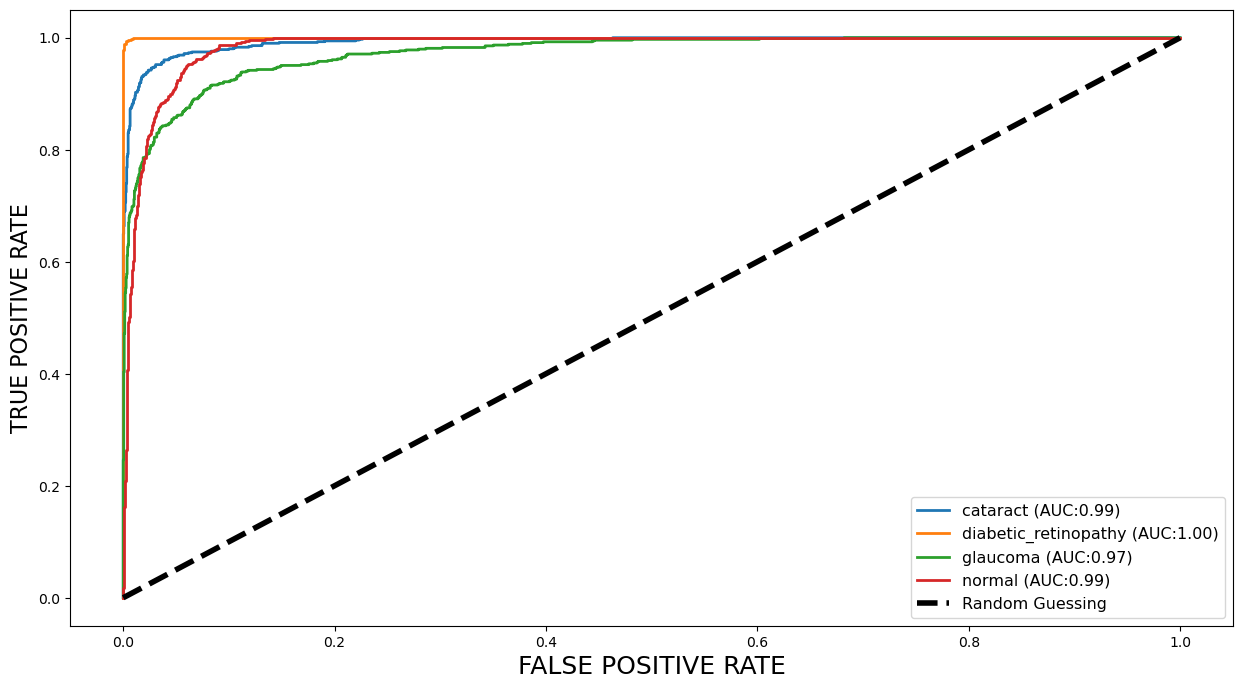

In [35]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# preds = model.predict(test_generator)
preds = predictions
# y_test = test_generator.classes
y_test = true_classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

#### 6.4.8 Saving the model

In [36]:
# Define a path where you want to save the model
model_path = "resnet50_modelp1.h5"

# Save the entire model
modelRN.save(model_path)

C:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 7. DenseNet121
A DenseNet is a type of convolutional neural network that utilises dense connections between layers, through Dense Blocks, where we connect all layers (with matching feature-map sizes) directly with each other.

### 7.1 Creating Subset

In [12]:
preprocess_input2 = tf.keras.applications.densenet.preprocess_input


#### 7.1.1 Creating Training Subset

In [13]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input2,
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = image_size,
    batch_size = batch_size,
    shuffle  = True , 
    class_mode = "categorical",
    subset='training'
)

Found 3376 images belonging to 4 classes.


#### 7.1.2 Creating Test Subset

In [14]:

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input2
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    shuffle  = False , 
    class_mode = "categorical",
)

Found 3050 images belonging to 4 classes.


#### 7.1.3 Ceating Validation Subset

In [15]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 841 images belonging to 4 classes.


### 7.2 Model

In [16]:
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam

# Create a base model for DenseNet-121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

num_classes = len(class_names)  # Replace with the number of classes in your dataset

# Add a dense layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
modelDN = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
modelDN.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
modelDN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 518, 518, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 256, 256, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1/conv[0][0]']      

 conv2_block4_0_bn (BatchNo  (None, 128, 128, 160)        640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 128, 128, 160)        0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 128, 128, 128)        20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 128, 128, 128)        512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 64, 64, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 64, 64, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 64, 64, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 64, 64, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 64, 64, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 64, 64, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 64, 64, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 64, 64, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 64, 64, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 64, 64, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 32, 32, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 32, 32, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 32, 32, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 32, 32, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 32, 32, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 32, 32, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 32, 32, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 32, 32, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 32, 32, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 32, 32, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 32, 32, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 32, 32, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 32, 32, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 32, 32, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 32, 32, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 32, 32, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 32, 32, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 32, 32, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 32, 32, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 32, 32, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 32, 32, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 32, 32, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 pool4_bn (BatchNormalizati  (None, 32, 32, 1024)         4096      ['conv4_block24_concat[0][0]']
 on)      

 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 16, 16, 608)          0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block4_1_conv (Conv2  (None, 16, 16, 128)          77824     ['conv5_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block4_1_bn (BatchNo  (None, 16, 16, 128)          512       ['conv5_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv5_block8_0_bn (BatchNo  (None, 16, 16, 736)          2944      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 16, 16, 736)          0         ['conv5_block8_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block8_1_conv (Conv2  (None, 16, 16, 128)          94208     ['conv5_block8_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block8_1_bn (BatchNo  (None, 16, 16, 128)          512       ['conv5_block8_1_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 16, 16, 864)          3456      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block12_0_relu (Acti  (None, 16, 16, 864)          0         ['conv5_block12_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block12_1_conv (Conv  (None, 16, 16, 128)          110592    ['conv5_block12_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_blo

 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 16, 16, 992)          3968      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block16_0_relu (Acti  (None, 16, 16, 992)          0         ['conv5_block16_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block16_1_conv (Conv  (None, 16, 16, 128)          126976    ['conv5_block16_0_relu[0][0]']
 2D)                                                                                              
          

### 7.3 Model Train & Validation

In [17]:
train_steps_per_epoch = train_generator.samples // batch_size
val_steps_per_epoch = validation_generator.samples // batch_size

In [18]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.train_acc = []
        self.train_loss = []
        self.val_acc = []
        self.val_loss = []
        self.batch_nums = []

    def on_train_batch_end(self, batch, logs=None):
        self.train_acc.append(logs.get('accuracy'))
        self.train_loss.append(logs.get('loss'))
        self.batch_nums.append(batch)

    def on_test_batch_end(self, batch, logs=None):
        self.val_acc.append(logs.get('accuracy'))
        self.val_loss.append(logs.get('loss'))

metrics_callback = MetricsCallback()

In [19]:
historyDN = modelDN.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[metrics_callback]
)

Epoch 1/15
52/52 [==============================] - 507s 10s/step - loss: 0.8819 - accuracy: 0.6552 - val_loss: 0.8244 - val_accuracy: 0.6779
Epoch 2/15
52/52 [==============================] - 493s 10s/step - loss: 0.5625 - accuracy: 0.7889 - val_loss: 0.7289 - val_accuracy: 0.7043
Epoch 3/15
52/52 [==============================] - 493s 10s/step - loss: 0.4696 - accuracy: 0.8303 - val_loss: 0.6981 - val_accuracy: 0.7127
Epoch 4/15
52/52 [==============================] - 493s 10s/step - loss: 0.4177 - accuracy: 0.8563 - val_loss: 0.6269 - val_accuracy: 0.7500
Epoch 5/15
52/52 [==============================] - 495s 10s/step - loss: 0.3833 - accuracy: 0.8741 - val_loss: 0.6940 - val_accuracy: 0.7260
Epoch 6/15
52/52 [==============================] - 496s 10s/step - loss: 0.3577 - accuracy: 0.8850 - val_loss: 0.5851 - val_accuracy: 0.7776
Epoch 7/15
52/52 [==============================] - 496s 10s/step - loss: 0.3356 - accuracy: 0.8913 - val_loss: 0.6685 - val_accuracy: 0.7344
Epoch 

### 7.4 Results

#### 7.4.1 Model Train Status

In [20]:
historyDN.history

{'loss': [0.8818641901016235,
  0.5625142455101013,
  0.46959611773490906,
  0.4176693260669708,
  0.383323073387146,
  0.35765916109085083,
  0.33561813831329346,
  0.3195062577724457,
  0.30406779050827026,
  0.2967205345630646,
  0.2804783582687378,
  0.27357760071754456,
  0.2676146924495697,
  0.26166924834251404,
  0.25504645705223083],
 'accuracy': [0.6551932096481323,
  0.7889492511749268,
  0.8303139805793762,
  0.8562802076339722,
  0.8740941882133484,
  0.8849637508392334,
  0.8913043737411499,
  0.8985507488250732,
  0.9009661674499512,
  0.9051932096481323,
  0.9112318754196167,
  0.9112318754196167,
  0.916968584060669,
  0.9118357300758362,
  0.91847825050354],
 'val_loss': [0.8243895173072815,
  0.7288922071456909,
  0.6980607509613037,
  0.6268946528434753,
  0.6940190196037292,
  0.585053026676178,
  0.6685056090354919,
  0.652782142162323,
  0.60838383436203,
  0.6370421051979065,
  0.6186237335205078,
  0.6409099102020264,
  0.6788492202758789,
  0.6332371234893799,

In [21]:
train_accuracy = historyDN.history['accuracy']
val_accuracy = historyDN.history['val_accuracy']
train_loss = historyDN.history['loss']
val_loss = historyDN.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)
train_accuracy
epochs

range(1, 16)

#### 7.4.2 Traning And Validation Accuracy

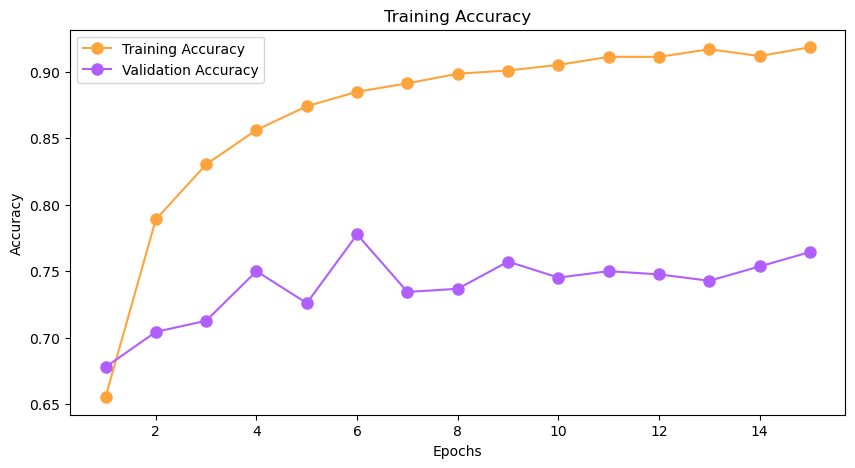

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
plt.plot(epochs, train_accuracy, '#FFA33C', marker='o', linestyle='-', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_accuracy, '#B15EFF',marker='o', linestyle='-', markersize=8, label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 7.4.3 Traning And Validation Loss

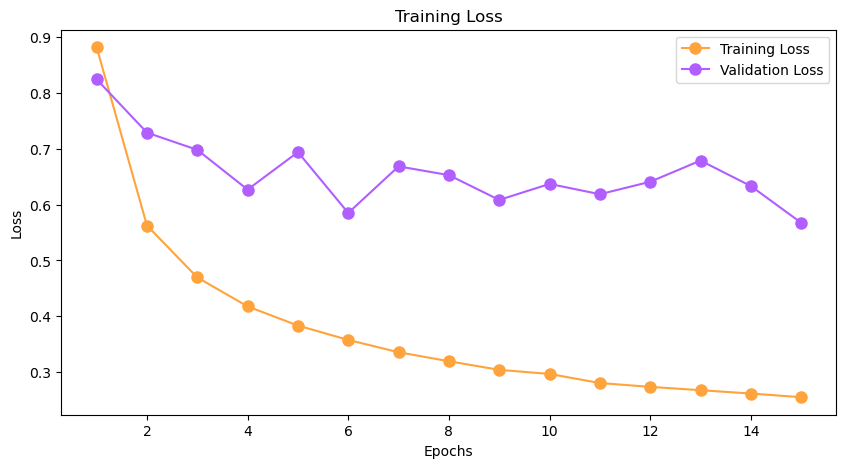

In [23]:
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, '#FFA33C', marker='o', linestyle='-', markersize=8, label='Training Loss')
plt.plot(epochs, val_loss, '#B15EFF', marker='o', linestyle='-', markersize=8, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 7.4.4 Data Prediction

In [24]:
predictions = modelDN.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

48/48 [==============================] - 373s 8s/step


In [25]:
predicted_classes

array([0, 0, 3, ..., 3, 3, 3], dtype=int64)

In [26]:
true_classes

array([0, 0, 0, ..., 3, 3, 3])

#### 7.4.5 Model Accuricy

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
class_labels = list(train_generator.class_indices.keys())
# class_labels = class_names
classification_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(classification_report)

                      precision    recall  f1-score   support

            cataract       0.90      0.91      0.91       752
diabetic_retinopathy       0.98      0.99      0.99       798
            glaucoma       0.88      0.69      0.77       725
              normal       0.79      0.94      0.86       775

            accuracy                           0.89      3050
           macro avg       0.89      0.88      0.88      3050
        weighted avg       0.89      0.89      0.88      3050



#### 7.4.6 Confusion Matrix

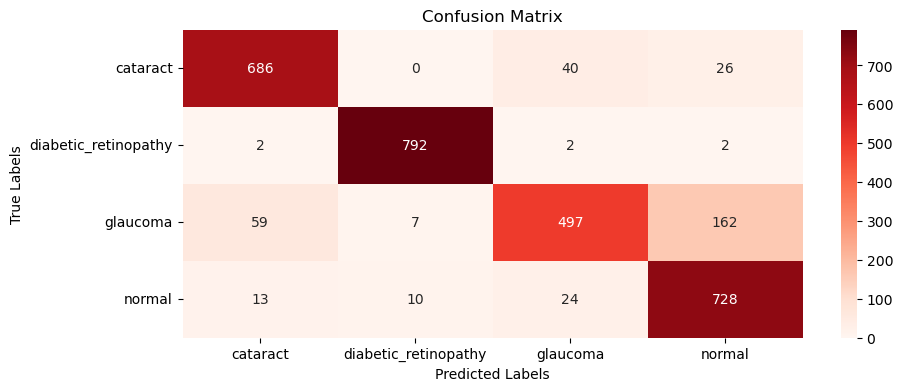

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### 7.4.7 ROC Curve

ROC AUC score: 0.9825310758756607


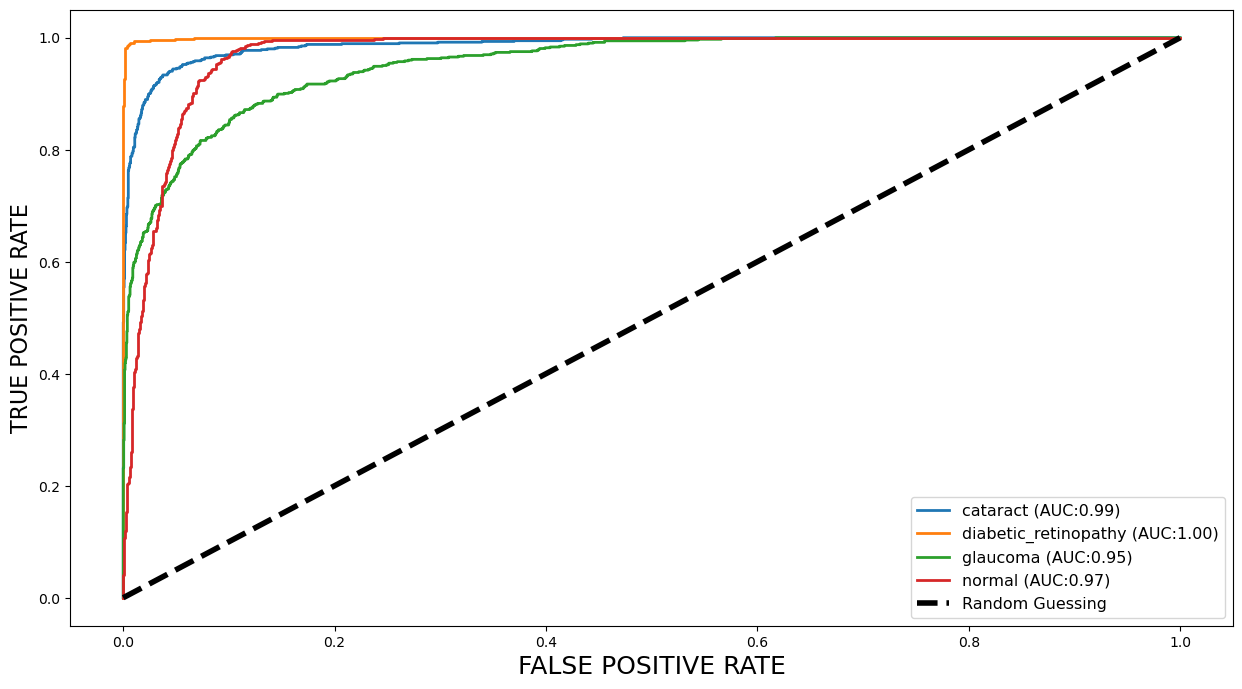

In [29]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# preds = model.predict(test_generator)
preds = predictions
# y_test = test_generator.classes
y_test = true_classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

#### 7.4.8 Saving the model

In [30]:
# Define a path where you want to save the model
model_path = "densenet121_modelp1.h5"

# Save the entire model
modelDN.save(model_path)

C:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
